In [1]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from bmi_topography import Topography
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider, SpaceLargeScaleEroder
from landlab.components.landslides import LandslideProbability
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask

# [Shallow Landslides](https://landlab.readthedocs.io/en/latest/reference/components/landslides.html)

In [90]:
# import small DEM
topo = Topography(
    dem_type="SRTMGL1",
    south=43.971911,
    north=43.982382,
    west=-123.826646,
    east=-123.813606,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )
fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    

In [91]:
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30) # 30 meters
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx

In [92]:
topographic_slope = grid.calc_slope_at_node(elevs='topographic__elevation')
slopes = grid.add_field('topographic__slope', topographic_slope, at='node', clobber=True) 

In [93]:
scatter_dat = np.random.randint(1, 10, grid.number_of_nodes)
grid.at_node['topographic__specific_contributing_area'] = np.sort(
     np.random.randint(30, 900, grid.number_of_nodes).astype(float))
# grid.at_node['soil__transmissivity'] = np.sort(
#      np.random.randint(5, 20, grid.number_of_nodes).astype(float), -1)
grid.at_node['soil__saturated_hydraulic_conductivity'] = np.sort(
     np.random.randint(2, 10, grid.number_of_nodes).astype(float), -1)
# grid.at_node['soil__mode_total_cohesion'] = np.sort(
#      np.random.randint(30, 900, grid.number_of_nodes).astype(float))
# grid.at_node['soil__minimum_total_cohesion'] = (
#      grid.at_node['soil__mode_total_cohesion'] - scatter_dat)
# grid.at_node['soil__maximum_total_cohesion'] = (
#      grid.at_node['soil__mode_total_cohesion'] + scatter_dat)
# grid.at_node['soil__internal_friction_angle'] = np.sort(
     # np.random.randint(26, 40, grid.number_of_nodes).astype(float))
# grid.at_node['soil__thickness'] = np.sort(
#      np.random.randint(1, 10, grid.number_of_nodes).astype(float))
# grid.at_node['soil__density'] = (2000. * np.ones(grid.number_of_nodes))

grid.at_node['soil__density'] = (1600. * np.ones(grid.number_of_nodes))
grid.at_node['soil__internal_friction_angle'] = 40. * np.ones(grid.number_of_nodes)
grid.at_node['soil__mode_total_cohesion'] = 48.5 * np.ones(grid.number_of_nodes)
grid.at_node['soil__minimum_total_cohesion'] = 3. * np.ones(grid.number_of_nodes)
grid.at_node['soil__maximum_total_cohesion'] = 94. * np.ones(grid.number_of_nodes)
grid.at_node['soil__thickness'] = 0.5 * np.ones(grid.number_of_nodes)
grid.at_node['soil__transmissivity'] = 65. * np.ones(grid.number_of_nodes)

In [94]:
LandslideProbability.var_help('soil__thickness')
# np.sort(np.random.randint(30, 900, grid.number_of_nodes).astype(float))

name: soil__thickness
description:
  soil depth to restrictive layer
units: m
unit agnostic: False
at: node
intent: in


In [95]:
ls_prob = LandslideProbability(grid)
np.allclose(grid.at_node['landslide__probability_of_failure'], 0.)

True

In [96]:
ls_prob.calculate_landslide_probability()

In [97]:
sorted(ls_prob.output_var_names) 

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__probability_of_saturation']

In [98]:
np.allclose(grid.at_node['landslide__probability_of_failure'], 0.)

False

In [99]:
core_nodes = ls_prob.grid.core_nodes

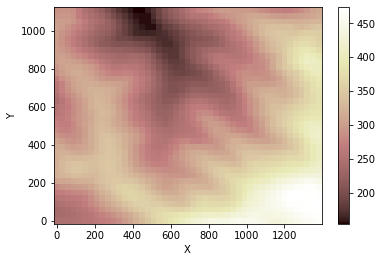

In [100]:
imshow_grid(grid, 'topographic__elevation')

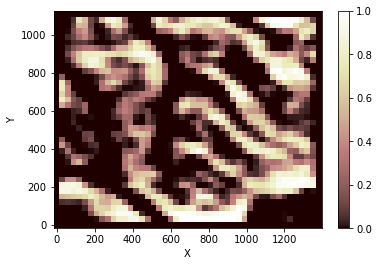

In [101]:
imshow_grid(grid, 'landslide__probability_of_failure')

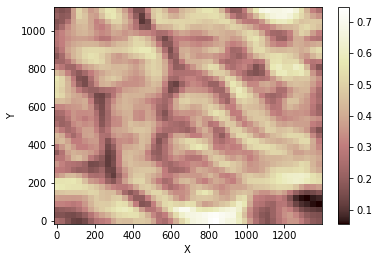

In [102]:
imshow_grid(grid, 'topographic__slope')

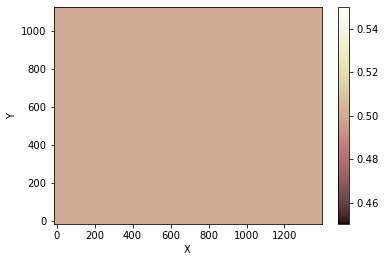

In [103]:
imshow_grid(grid, 'soil__thickness')

In [86]:
def list_keys(grid):
    for group in grid.groups:
        for field in grid.keys(group):
            print(field)
list_keys(grid)

topographic__elevation
topographic__slope
topographic__specific_contributing_area
soil__saturated_hydraulic_conductivity
soil__density
soil__internal_friction_angle
soil__mode_total_cohesion
soil__minimum_total_cohesion
soil__maximum_total_cohesion
soil__thickness
soil__transmissivity
soil__mean_relative_wetness
landslide__probability_of_failure
soil__probability_of_saturation
